In [1]:
%matplotlib widget
import numpy as np
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

# Load scan

In [4]:
pgroup = 'p22587'

#runlist = np.arange(63, 73)
runlist = [38]

##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print ("will reduce {} run(s): {}".format(len(jsonlist), runlist))
titlestring = pgroup + ' --- ' +str(runlist)
jsonlist

will reduce 1 run(s): [38]


['/sf/alvra/data/p22587/raw/run0038-XANES_FAP_GS/meta/scan.json']

In [3]:
#channel_diode_1 = 'SARES12-GES1:PR1_CH1_VAL_GET'
#channel_diode_2 = 'SARES12-GES1:PR1_CH2_VAL_GET'

In [8]:
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

dir2save = 'static'

saveflag = True
#########################################################
reducedir='/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, dir2save)
unpump_1, unpump_2, Izero_unpump, energy, energypad, readbacks, corr1, corr2 = \
Reduce_scan_static(reducedir, saveflag, jsonlist, detector_XAS_1, detector_XAS_2, detector_Izero)

#Plot_correlations_scan(pgroup, reducedir, runlist, timescan=False)#, lowlimit = 0.5)

/sf/alvra/data/p22587/raw/run0038-XANES_FAP_GS/meta/scan.json
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-CVME-EVR0:DUMMY_PV3_NBS 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET    501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH2_VAL_GET    501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY       499 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 501 -> 0% loss
complete channels: 4 / 5 -> 20% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 100.0 Hz (delayed or dark)
Pump scheme is 0:1
Loaded 0 pump and 499 unpump shots
correlation Diode1 (dark shots) = 0.8482673724077461
correlation Diode2 (dark shots) = 0.9883021109531983
----------------------------
Loaded 20488 total shots


40 41 (41,)


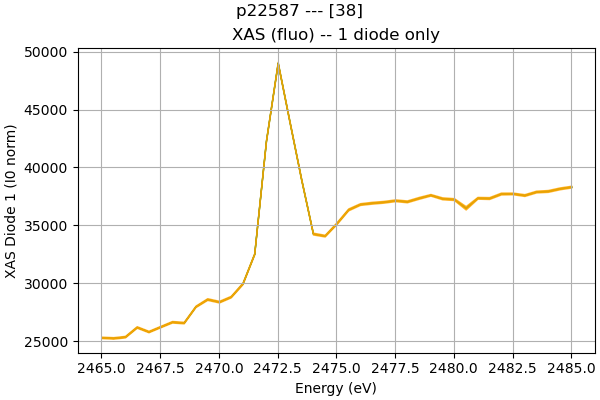

In [11]:
rbk = readbacks[0]
GS, err_GS, err_GS2 = Rebin_energyscans_static(unpump_2, Izero_unpump, energypad, rbk)

fig, (ax1) = plt.subplots(figsize=(6, 4), constrained_layout=True)
plt.suptitle(titlestring)

ax1.fill_between(rbk, GS-err_GS2, GS+err_GS2, label='error of the mean',color='green', alpha = 0.8)
ax1.fill_between(rbk, GS-err_GS, GS+err_GS, label='err propagation',color='orange', alpha = 0.8)
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo) -- 1 diode only')
#ax1.legend(loc="lower right")
ax1.grid()

plt.show()


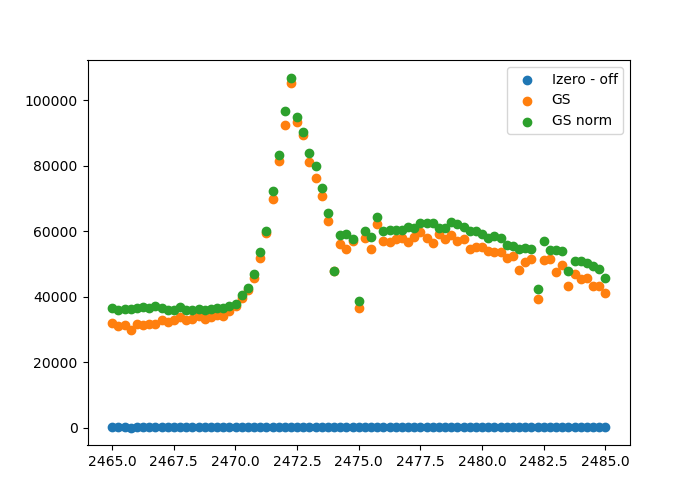

In [82]:
GS = unpump_1

ordered = np.argsort(np.asarray(energypad))
peaks, what = find_peaks(np.diff(np.array(energypad)[ordered]))

Izero_unpump = np.array(Izero_unpump)[ordered]

starts = np.append(0, peaks)
ends = np.append(peaks, None)

I0u = []
G = []

for s, e in zip(starts, ends):
    Izero = Izero_unpump[s:e]
    GSs = GS[s:e]
    I0u.append(np.mean(Izero))
    G.append(np.mean(GSs))

plt.figure(figsize=(7,5))
#plt.suptitle(titlestring_stack+' -- 1 diode')
#plt.scatter (energy, Izero_pump, label='Izero - off', s=0.5)
plt.scatter(readbacks[0], I0u, label='Izero - off')
plt.scatter(readbacks, np.array(G), label='GS')
plt.scatter(readbacks, np.array(G)/np.array(I0u), label='GS norm')
plt.legend(loc='best')
plt.show()

# Plot averaged data

[93]
1 scan(s), 6337 total on/off shots


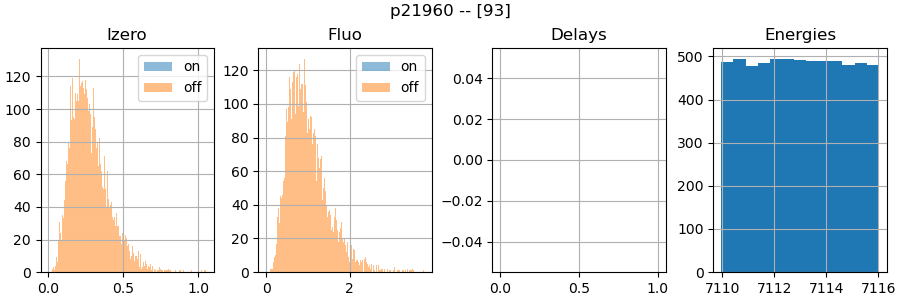

Time delay axis rebinned with delay stage data


In [7]:
pgroup = 'p21960'
Loaddir_name = 'static'

#runlist = np.arange(45, 48)
runlist = [93]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
#firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
firstrun = glob.glob('/sf/alvra/data/{}/work/testdata/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist, average_twodiodes=False)

globals().update(data)
print (runlist)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(unpump_1)))

Plot_reduced_data(data, scan, titlestring_stack, withTT=False)


unpump_1     = np.asarray(unpump_1)
Izero_unpump = np.asarray(Izero_unpump)
energy       = np.asarray(energy)
readbacks    = np.asarray(readbacks)

In [8]:
quantile = 0.8

################################
rbk = readbacks[0]
GS, err_GS, err_GS2 = Rebin_and_filter_energyscans_static(data, quantile, rbk)

12 13 (13,)


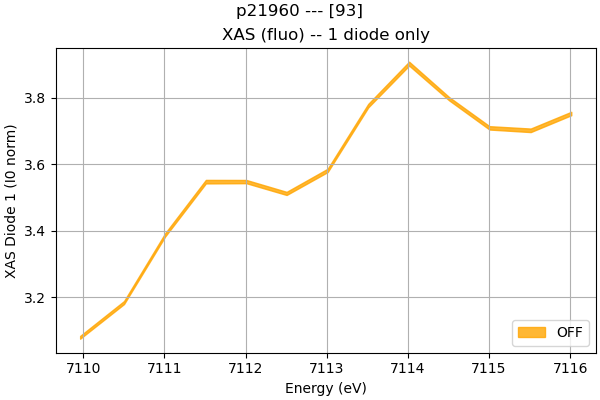

In [9]:
fig, (ax1) = plt.subplots(figsize=(6, 4), constrained_layout=True)
plt.suptitle(titlestring_stack)

ax1.fill_between(rbk, GS-err_GS, GS+err_GS, label='OFF',color='orange', alpha = 0.8)

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo) -- 1 diode only')
ax1.legend(loc="lower right")
ax1.grid()

plt.show()

# Overlay data

In [3]:
pgroup = 'p21960'

#runlist = np.arange(45, 48)
runlist = [93]

Loaddir_folder = 'static'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)

titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 1 runs: [93] from /sf/alvra/data/p21960/work/Reduced_data/static/


['/sf/alvra/data/p21960/work/Reduced_data/static/run0093-MbCO_XANES_preedge_500fs/run_array.npy']

12 13 (13,)


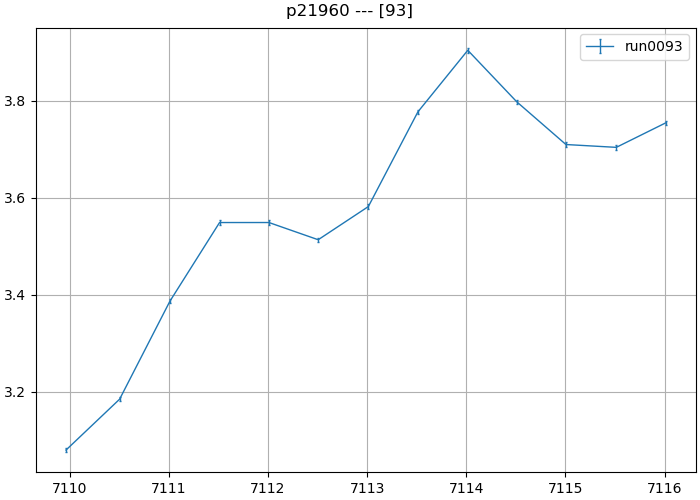

In [9]:
quantile = 0.7
average_twodiodes = False

####################################################

fig, ((ax1)) = plt.subplots(figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    runname = 'run{:04d}'.format(run)
    data = {}
    data, _ = load_reduced_data(pgroup, Loaddir, [run], average_twodiodes)
    globals().update(data)
    #runname = np.asarray(data['name'])[0]
    rbk = np.asarray(data['readbacks'])[0]

    GS, err_GS, err_GS2 = \
    Rebin_and_filter_energyscans_static(data, quantile, rbk)

    ax1.errorbar(rbk, GS, err_GS, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+' '+str(lab[index]))
ax1.legend()
ax1.grid()
